### ISO 281
___

Calculate L10 life (rolling contact fatigue) using ISO 281 method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import glob
import os
from post_process import import_TB_runs
import scipy.stats as ss
pd.options.mode.chained_assignment = None   # off with setwithcopy warning

#### Classes

In [2]:
class brg_design():
    # dimensions, dynamic axial rating
    def __init__(self,i,z,dw,alpha,dp,pu,kind,ca_manuf=None):
        # attributes of a bearing       
        self.i = i # no. of rows
        self.z = z # no. of brgs in a row
        self.dw = dw # diameter of indiv. brg  mm
        self.alpha = alpha # contact angle in degrees
        self.dp = dp # pitch diameter m
        self.pu = pu    # fatigue limit load (from manufacturers catalogue)  in N
        self.kind = kind
        if self.kind == 'ball':
            self.p = 3
        else:
            self.p = 3.3
        self.ca_manuf = ca_manuf # axial load rating (from manuf. catalogue else can calculate)  N
    
    def Ca_rot(self,fc):
        # brg dynamic axial load rating rotational
        if self.kind == 'ball':
            ca = (3.647*(self.i*fc*np.cos(np.deg2rad(self.alpha))**0.7)*(self.z**(2/3))*(self.dw**1.4)*np.tan(np.deg2rad(self.alpha)))
        else:
            ca = ((self.i*fc*np.cos(np.deg2rad(self.alpha))**0.7)*(self.z**(2/3))*(self.dw**1.4)*np.tan(np.deg2rad(self.alpha)))
        return ca


In [3]:
class load_case_comb():
    # combine TB load cases for each tidal profile and calculate theta, N, P
    
    def __init__(self,file_location,col_headers,brg_p):
        self.file_location = file_location
        self.col_headers = col_headers
        self.brg_p = brg_p
        
    def load_TB_data(self):
        # load raw load case data from TB
        sim_data = [import_TB_runs(os.listdir(self.file_location)[i],self.file_location,self.col_headers) for i in range(len(os.listdir(self.file_location)))]
        return sim_data
    
    def lc_df(self,brg_dp):
        # units are kN and m
        TB_data = self.load_TB_data()
        Fr = [np.sqrt((np.sum((np.absolute(TB_data[i]['Fxy'])**2))/np.size(TB_data[i]['Fxy']))) for i in range(len(TB_data))]
        Fa = [np.sqrt((np.sum((np.absolute(TB_data[i]['Fz'])**2))/np.size(TB_data[i]['Fz'])))for i in range(len(TB_data))]
        My = [np.sqrt((np.sum((np.absolute(TB_data[i]['My'])**2))/np.size(TB_data[i]['My'])))for i in range(len(TB_data))]
        P_eak = [(0.75*Fr[i])+(Fa[i])+(2*My[i]/(brg_dp/1000)) for i in range(len(TB_data))]
        osc_amp = [abs(TB_data[i]['PS deg'].diff()).mean() for i in range(len(TB_data))]
        osc_opm = [(abs(TB_data[i]['PS deg'].diff()).sum()/(len(TB_data[i]['PS deg'])/60)) for i in range(len(TB_data))]
        df = pd.DataFrame({'Osc_amp deg':osc_amp,'Speed opm':osc_opm,'Fr rms':Fr,'Fa rms':Fa,'My rms': My,'Dyn Equiv Load':P_eak})
        return df

In [4]:
class tidal_profile_comb():
    # combine equivalent loads from each load case and calc P_osc, theta_equiv and N_ave

    def __init__(self,duty_cycles,load_cases,brg_p,Ca,z):
        self.duty_cycles = duty_cycles   # list of time fractions
        self.load_cases = load_cases   # list of dataframes
        self.brg_p = brg_p
        self.Ca = Ca
        self.z = z

    def tp_comb(self):
        # combine load case dataframes and calculate dyn_equiv_osc
        df = pd.concat(self.load_cases,ignore_index=True)
        df['Duty Cycle'] = self.duty_cycles
        return df
    
    def dyn_equiv_osc(self):
        df = self.tp_comb()
        numerator = np.sum((df['Dyn Equiv Load']**self.brg_p)*df['Speed opm']*df['Duty Cycle']*df['Osc_amp deg'])
        denominator = np.sum(df['Speed opm']*df['Duty Cycle']*df['Osc_amp deg'])
        return (numerator/denominator)**(1/self.brg_p)

    def N_opm_ave(self):
        # N_ave
        n_ave = np.sum(self.tp_comb()['Speed opm']*self.tp_comb()['Duty Cycle'])
        return n_ave

    def theta_equiv(self):
        # theta equivalent       
        numerator = np.sum(self.tp_comb()['Speed opm']*self.tp_comb()['Duty Cycle']*self.tp_comb()['Osc_amp deg'])
        denominator = np.sum(self.tp_comb()['Speed opm']*self.tp_comb()['Duty Cycle'])
        return (numerator/denominator) 

    def Ca_osc(self):
        # brg dynamic axial load rating oscillatory
        if self.brg_p == 3.3:
            ca_osc = self.Ca*((180/self.theta_equiv())**(2/9))*(self.z**0.028)
        else:
            ca_osc = self.Ca*((180/self.theta_equiv())**(3/10))*(self.z**0.033)
        return ca_osc


In [5]:
class life_calcs():
    # l10 life by ISO 281 method
    def __init__(self,brg_ca_osc,Pea_osc,kind,dp,lub_contam_level,pu,rel_level,k=0.076):
        self.brg_ca_osc = brg_ca_osc   # brg osc axial load rating
        self.Pea_osc = Pea_osc  # oscillatory dynamic equivalent load
        self.kind = kind   # brg type
        self.dp = dp    # pitch diameter of brg mm
        self.lub_contam_level = lub_contam_level  # level of contamination in brg grease lubricant (see Table 7 NREL DG03)
        self.k = k   # measure of adequacy of lubrication (for yaw, pitch brgs assumed to be 0.076 see NREL DG03)
        if self.kind == 'ball':
            self.p = 3
        else:
            self.p = 3.3
        self.pu = pu  # bearing fatigue limit (from manufacturers catalogue)
        self.rel_level = rel_level
        
    def eta(self):
        # parameter of a_iso calculation
        # level of particulate contam in grease lubricant
        contam_table = pd.DataFrame({'Contam Level':['high cleanliness','normal cleanliness','typical contamination','severe contamination','very severe contamination'],
               'c1':[0.0864,0.0432,0.0177,0.0115,0.00617],'c2':[0.6796,1.141,1.887,2.662,4.06]})
        eta = 0.173*contam_table.loc[contam_table['Contam Level']==self.lub_contam_level]['c1'].values*(self.k**0.68)*(self.dp**0.55)*(1-(contam_table.loc[contam_table['Contam Level']==self.lub_contam_level][['c2']].values/(self.dp**(1/3))))
        return eta
    
    def a_iso(self):
        # ISO correction factor
        if self.kind == 'ball':
            params = [2.5671,2.2649,0.053481,0.83,0.333,-9.3]
        else:
            params = [1.5859,1.3993,0.054381,1,0.4,-9.185]
        a_iso = 0.1*(1-((params[0]-(params[1]/(0.076**params[2])))**params[3])*(((self.eta()*self.pu)/self.Pea_osc)**params[4]))**params[5]
        return a_iso[0][0]
    
    def a1(self):
        # a1 life modification factor
        a1_table = pd.DataFrame({'Reliability %':[90,95,96,97,98,99,99.95],'a1':[1,0.64,0.55,0.47,0.37,0.25,0.077]})
        a1 = a1_table.loc[a1_table['Reliability %']==self.rel_level]['a1']
        return a1
    
    def L10_mill_osc(self):
        # L10 ISO life equation (millions of oscillations)
        l10 = self.a_iso()*self.a1()*(self.brg_ca_osc/self.Pea_osc)**self.p
        return l10[0]
    
    def L10_hrs(self,N_ave):
        # L10 ISO life equation (hrs)
        l10 = (self.L10_mill_osc()*1000000)/(N_ave*60)
        return l10

___

#### Program Run

In [6]:
# Run brg_design - choose brg design parameters
# Run load_case_comb  - combine load cases from each tidal profile
# Run tidal_profile_comb - combine all tidal profiles with duty cycle info
# Run life_calcs - to get lifetime estimation

In [7]:
file_location_fld = r'C:\Users\FREWIN\OneDrive - DNV GL\Atlantis\Runs\PHM LC\TB data\Floods' 
file_location_ebb = r'C:\Users\FREWIN\OneDrive - DNV GL\Atlantis\Runs\PHM LC\TB data\Ebbs' 
cols = 'Time','PS deg','Fxy','Fz','My'
skf_8110 = brg_design(1,31,77.5,45,839,800000,'roller',ca_manuf=5390000)  # bearing object  i,z,dw,alpha,dp,pu,kind
brg = skf_8110  # Hybrid of Atlantis 8110 and skf 8010
duty_cycles = [0.062,0.062,0.038,0.038,0.062,0.068,0.057,0.078,0.054,0.046,
              0.072,0.068,0.032,0.065,0.046,0.035,0.068,0.027,0.016,0.011]
fld_lc = load_case_comb(file_location_fld,cols,brg_p=brg.p)  # load case object (may have several of these)
ebb_lc = load_case_comb(file_location_ebb,cols,brg_p=brg.p)  # load case object (may have several of these)
t_profiles = tidal_profile_comb(duty_cycles,[fld_lc.lc_df(brg.dp),ebb_lc.lc_df(brg.dp)],brg.p,brg.ca_manuf,brg.z)
life = life_calcs(t_profiles.Ca_osc(),t_profiles.dyn_equiv_osc(),'roller',brg.dp,'high cleanliness',brg.pu,90)

In [8]:
life.L10_hrs(t_profiles.N_opm_ave()),life.L10_mill_osc()

(68577.81668164778, 86.93837916119983)

#### Reliability Plots

In [9]:
### assuming Beta param of 1.5, Eta is calculated using probability paper (Weibull probability plot)

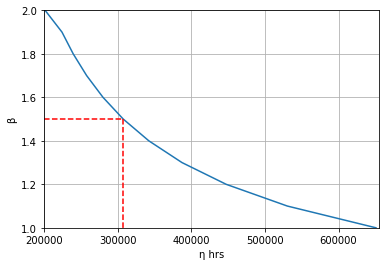

In [57]:
beta = np.linspace(1,2,11)
eta = [650880,530461,447315,387226,342189,307416,279901,257676,239406,224160,201271]
plt.plot(eta,beta)
plt.plot([200000,307000],[1.5,1.5],ls='--',c='r')
plt.plot([307000,307000],[1.5,1],ls='--',c='r')
plt.xlabel('η hrs')
plt.ylabel('β')
plt.xlim([200000,655000])
plt.ylim([1,2])
plt.grid()

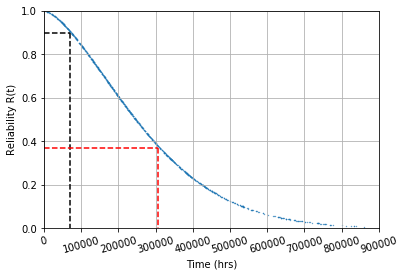

In [74]:
rvs = ss.weibull_min.rvs(c=1.5,loc=0,scale=307416,size=1000)
c,loc,scale = ss.weibull_min.fit(rvs,loc=0)
sf = ss.weibull_min.sf(rvs,c,loc,scale)
fig,ax = plt.subplots()
ax.scatter(rvs,sf,s=0.1)
ax.set(xlabel='Time (hrs)',ylabel='Reliability R(t)',xlim=[0,900000],ylim=[0,1])
ax.plot([0,68577],[0.9,0.9],ls='--',c='k')
ax.plot([68577,68577],[0.9,0],ls='--',c='k')
ax.plot([0,307416],[0.368,0.368],ls='--',c='r')
ax.plot([307416,307416],[0.368,0],ls='--',c='r')
plt.grid()
_=plt.xticks(rotation=15)

#### Calibration of PS Angle

In [11]:
# Assuming 1 year of operation with 98% availability

In [12]:
raw_ps = pd.read_csv('PitchAngleFiltered.csv',header=None)

In [13]:
cols = '?','Date_Time','?','Angle deg'
raw_ps.columns = cols
ps_data = raw_ps[['Date_Time','Angle deg']]
ps_data['Date_Time'] = pd.to_datetime(ps_data['Date_Time'])

In [14]:
from functions import rounding
ts = rounding(ps_data)

In [15]:
ps_ts = ts['2017-03-13 00:00':'2017-03-13 12:00']

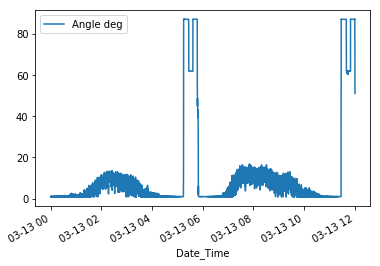

In [16]:
ps_ts.plot(use_index=True)

#### TEST ZONE: Distribution of MY

In [17]:
# RUL = historical / rated oscillation value

In [18]:
def log_norm_fit(data):
    # fit lognormal dist
    shape,loc,scale = ss.lognorm.fit(data/1000000)
    rvs = ss.lognorm.rvs(s=shape,loc=loc,scale=scale,size=len(data))
    pdf = ss.lognorm.pdf(np.sort(rvs),s=shape,loc=loc,scale=scale)
    return {'pdf':pdf,'rvs':np.sort(rvs)}

In [19]:
My_fld_data = [fld_lc.load_TB_data()[i]['My'] for i in range(len(fld_lc.load_TB_data()))]
My_ebb_data = [ebb_lc.load_TB_data()[i]['My'] for i in range(len(ebb_lc.load_TB_data()))]
Myf_pdf = log_norm_fit(pd.concat(My_fld_data))
Mye_pdf = log_norm_fit(pd.concat(My_ebb_data))

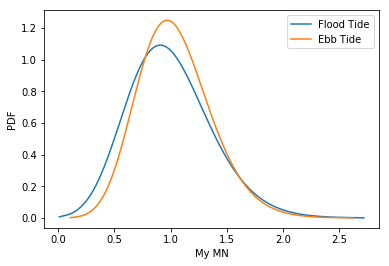

In [20]:
fig,ax = plt.subplots()
_=ax.plot(Myf_pdf['rvs'],Myf_pdf['pdf'],label='Flood Tide')
_=ax.plot(Mye_pdf['rvs'],Mye_pdf['pdf'],label='Ebb Tide')
_=plt.legend()
_=ax.set(xlabel='My MN',ylabel='PDF')

In [21]:
fld_lc.lc_df(brg.dp)['Speed opm'].mean(),ebb_lc.lc_df(brg.dp)['Speed opm'].mean()

(24.823368504201685, 16.533859542857144)

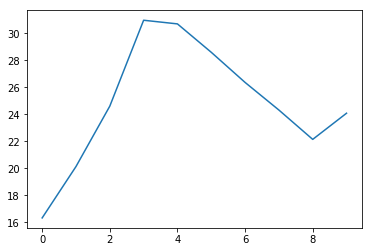

In [22]:
fld_lc.lc_df(brg.dp)['Speed opm'].plot()

In [23]:
plot_data = My_pdf
labels = '3.06ms','3.19','3.32','3.45','3.58','3.71','3.84','3.97','4.1','4.23'
fig,ax = plt.subplots()
for i in range(len(plot_data)):
    ax.plot(plot_data[i]['rvs'],plot_data[i]['pdf'],label=labels[i])
    ax.set(xlabel='My MN',ylabel='PDF')
    _=plt.legend()

NameError: name 'My_pdf' is not defined